Data processing for super-greenhouse climatology \
Original AIRS L3 1deg data: https://disc.gsfc.nasa.gov/datasets/AIRX3STD_006/ \
and https://disc.gsfc.nasa.gov/datasets/AIRS3STD_006/ \
Original CERES SSF1deg_day Aqua data: https://ceres.larc.nasa.gov/data/#ssf1deg-level-3 \
~20 yrs of data, from September 2002 to December 2022. 35S to 35N, ocean only.

Maura Dewey (maura.dewey@misu.su.se), 2023


### 1. data prep
assumes satellite data is available locally. 
if SGE_timeseries.nc is available, skip to part 2 for paper figures.

In [1]:
import netCDF4 as nc
import xarray as xr
from pyhdf.SD import SD, SDC
import numpy as np
import pandas as pd
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime, timedelta
from os import path
import matplotlib.gridspec as gridspec
import seaborn as sns 
import cartopy
from statsmodels.tsa.seasonal import STL
import cmasher as cm


In [146]:
ceres_dp = '/nazko/home/mdewey/Data/CERES/SSF1deg_day/Aqua/'
airs_dp = '/nazko/home/mdewey/Data/AIRS/l3_1deg_hdf/'

In [10]:
#setup prerequisite files for Earthdata credentials (works for Linux, Mac, Windows)
#run if you need credentials setup for downloading data. Otherwise unecessary if data is available locally.
#from: https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files
from subprocess import Popen
from getpass import getpass
import platform
import os
import shutil

urs = 'urs.earthdata.nasa.gov'    # Earthdata URL to call for authentication
prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
           'Enter NASA Earthdata Login Password: ']

homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.netrc', 'w') as file:
    file.write('machine {} login {} password {}'.format(urs, getpass(prompt=prompts[0]), getpass(prompt=prompts[1])))
    file.close()
with open(homeDir + '.urs_cookies', 'w') as file:
    file.write('')
    file.close()
with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .netrc, .urs_cookies, and .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows  
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

Saved .netrc, .urs_cookies, and .dodsrc to: /home/mdewey/


In [144]:
#utils
def grey_atmos(x,a,b):
    #x: surface temperature
    #a: parameter describing the surface temperature dependent contribution of dry atmosphere to the optical depth 
    #b: parameter describing the surface temperature dependent contributino of water vapour to the optical depth
    sigma=5.670374419E-8
    tau_wet=b*(x-220)
    tau=a+tau_wet
    y=sigma*(x**4)*(1-1/((3/4)*tau+(1/2)))
    return y

def SGE_threshold(T,OLR,TPWV):
    #T: surface temperature [K]
    #OLR: outgoing longwave radiation [W/m^2]
    #TPWV: total precitable water [kg/m^2]
    #SGE_occ: grid passes threshold (1=yes, 0=no)
    #SGE_strength: difference between expected and measured OLR [W/m^2]
    sigma=5.670374419E-8
    H2O_threshold=40
    OLR_expected=sigma*(T**4)-grey_atmos(T,0.84454868,0.00804156)
    SGE_occ=xr.where(np.logical_and((OLR-OLR_expected)<0, TPWV>H2O_threshold), np.ones_like(OLR), 0)
    SGE_strength=(OLR_expected-OLR)*SGE_occ
    return SGE_occ, SGE_strength


def earth_radius(lat):
    '''
    -----------
    https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    WGS84: https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf
    '''
    from numpy import deg2rad, sin, cos

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )
    return r

def shift_lon(df):
    #shift airs data from [-180,180] to [0,360]
    lon_atrib = df.coords['lon'].attrs
    df.coords['lon'] = df.coords['lon'] % 360
    df = df.sortby(df.lon)
    df.coords['lon'].attrs = lon_atrib
    return df

def get_AIRS_files(dateStart,dateEnd):
    #modified from https://stackoverflow.com/questions/31821098/getting-file-from-date-range-of-the-current-directory

    CERES_DATE_FORMAT = '%Y%m%d'
    AIRS_DATE_FORMAT = r'AIRS.%Y.%m.%d'
    AIRS_PATH_FORMAT = airs_dp+r'%Y'
    start_date = datetime.strptime(dateStart, CERES_DATE_FORMAT).date()
    end_date = datetime.strptime(dateEnd, CERES_DATE_FORMAT).date()
    delta_one_day = timedelta(days=1)
    AIRS_files = []
    date = start_date
    while date <= end_date:
        data_folder = date.strftime(AIRS_PATH_FORMAT)
        if path.isdir(data_folder):
            for filename in glob(data_folder+'/'+date.strftime(AIRS_DATE_FORMAT)+'*.hdf'):
                AIRS_files.append(filename)
        date += delta_one_day 
    return AIRS_files

# a couple of preprocess setps to speed up open_mfdataset for CERES files
def olrc_preprocess(ds):
    return ds['toa_lw_clr_daily'].sel(lat=slice(-34.5,34.5))

def olra_preprocess(ds):
    return ds['toa_lw_all_daily'].sel(lat=slice(-34.5,34.5))

def time_preprocess(ds):
    return ds['time']

def h2o_preprocess(ds):
    return ds['aux_precipw_daily'].sel(lat=slice(-34.5,34.5))

def sst_preprocess(ds):
    return ds['aux_skint_daily'].sel(lat=slice(-34.5,34.5))

{'TotalCounts_A': (('YDim:ascending', 'XDim:ascending'), (180, 360), 22, 0), 'SurfPres_Forecast_A': (('YDim:ascending', 'XDim:ascending'), (180, 360), 5, 1), 'SurfPres_Forecast_A_ct': (('YDim:ascending', 'XDim:ascending'), (180, 360), 22, 2), 'SurfPres_Forecast_A_sdev': (('YDim:ascending', 'XDim:ascending'), (180, 360), 5, 3), 'SurfPres_Forecast_A_min': (('YDim:ascending', 'XDim:ascending'), (180, 360), 5, 4), 'SurfPres_Forecast_A_max': (('YDim:ascending', 'XDim:ascending'), (180, 360), 5, 5), 'SurfSkinTemp_A': (('YDim:ascending', 'XDim:ascending'), (180, 360), 5, 6), 'SurfSkinTemp_A_ct': (('YDim:ascending', 'XDim:ascending'), (180, 360), 22, 7), 'SurfSkinTemp_A_sdev': (('YDim:ascending', 'XDim:ascending'), (180, 360), 5, 8), 'SurfSkinTemp_A_min': (('YDim:ascending', 'XDim:ascending'), (180, 360), 5, 9), 'SurfSkinTemp_A_max': (('YDim:ascending', 'XDim:ascending'), (180, 360), 5, 10), 'SurfSkinTemp_A_err': (('YDim:ascending', 'XDim:ascending'), (180, 360), 5, 11), 'EmisIR_A': (('EmisFre

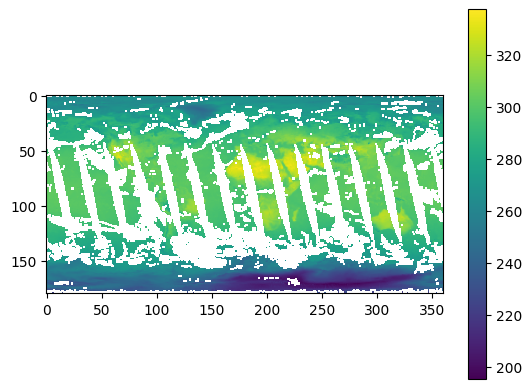

In [4]:
#test access to AIRS data, plot example:
#see https://hdfeos.org/software/pyhdf.php

# Open file.
FILE_NAME = airs_dp + '2002/AIRS.2002.09.01.L3.RetStd001.v6.0.9.0.G13208004820.hdf'
hdf = SD(FILE_NAME, SDC.READ)

# List available SDS datasets.
print(hdf.datasets())

# Read dataset.
DATAFIELD_NAME='SurfSkinTemp_A'
data = hdf.select(DATAFIELD_NAME).get()
data_clean = np.where(data != -9999.0, data, np.NaN)
lat = hdf.select('Latitude').get()
latitude = lat[:,1]
lon = hdf.select('Longitude').get()
longitude = lon[1,:]

plt.imshow(data_clean)
plt.colorbar()

file_date = datetime.datetime.strptime(FILE_NAME[-49:-39],'%Y.%m.%d')

sst = xr.DataArray(data_clean, 
coords={'lat': latitude,'lon': longitude,'time': file_date}, 
dims=["lat", "lon"])

In [147]:
SGE_occ_all = []
SGE_occ_clr = []
SGE_str_all = []
SGE_str_clr = []
no_airs_ = []

#get AIRS landseamask, lat, lon only once:
FILE_NAME = airs_dp + '2002/AIRS.2002.09.01.L3.RetStd001.v6.0.9.0.G13208004820.hdf'
hdf = SD(FILE_NAME, SDC.READ)
lat = hdf.select('Latitude').get()
AIRS_latitude = lat[:,1]
lon = hdf.select('Longitude').get()
AIRS_longitude = lon[1,:]

mask = hdf.select('LandSeaMask').get()
seamask = xr.DataArray(mask, 
        coords={'lat': AIRS_latitude,'lon': AIRS_longitude}, 
        dims=["lat", "lon"]).sortby('lat').sel(lat=slice(-34.5,34.5))
landmask = shift_lon(np.logical_not(seamask))

for yr in range(2022,2023):
    ceres_files = sorted(glob(ceres_dp + '*_' + str(yr) + '*.nc'), key=lambda v: v.split('/')[-1:][0][-20:-12])

    #some files in different uvic folder:
    if yr==2022:
        ceres_files ='/home/mdewey/CERES_SSF1deg-Day_Aqua-MODIS_Ed4.1_Subset_20220101-20221231(3).nc'
        AIRS_files = get_AIRS_files('20220101','20221231')
    else:
        #get list of AIRS files which overlap current CERES files:
        CERES_start_date = ceres_files[0].split('/')[-1:][0][-20:-12]
        CERES_end_date = ceres_files[-1].split('/')[-1:][0][-11:-3]
        AIRS_files = get_AIRS_files(CERES_start_date, CERES_end_date)

    #get CERES data:
    OLR_all = xr.open_mfdataset(ceres_files,preprocess=olra_preprocess,combine='nested',concat_dim='time').drop_duplicates(dim='time')
    OLR_clr = xr.open_mfdataset(ceres_files,preprocess=olrc_preprocess,combine='nested',concat_dim='time').drop_duplicates(dim='time')
    CERES_dates_org = xr.open_mfdataset(ceres_files,preprocess=time_preprocess,combine='nested',concat_dim='time').drop_duplicates(dim='time')

    #normalize dates:
    OLR_all['time'] = OLR_all.indexes['time'].normalize()
    OLR_clr['time'] = OLR_clr.indexes['time'].normalize()

    SST_=[]
    TOTVAP_=[]

    #get AIRS data:
    for airs_fn in AIRS_files:
        file_date = datetime.strptime(airs_fn.split('/')[-1:][0][5:15],'%Y.%m.%d')
        hdf= SD(airs_fn, SDC.READ)

        #daily mean of ascending and desending modes
        sstA_ = hdf.select('SurfSkinTemp_A').get()
        sstA_clean = np.where(sstA_ != -9999.0, sstA_, np.NaN)
        sstD_ = hdf.select('SurfSkinTemp_D').get()
        sstD_clean = np.where(sstD_ != -9999.0, sstD_, np.NaN)
        sst_ = np.nanmean(np.stack((sstA_clean, sstD_clean)),axis=0)
        sst = xr.DataArray(sst_, 
        coords={'lat': AIRS_latitude,'lon': AIRS_longitude,'time': file_date}, 
        dims=["lat", "lon"])
        SST_.append(sst)
    
        h2oA_ = hdf.select('TotH2OVap_A').get()
        h2oA_clean = np.where(h2oA_ != -9999.0, h2oA_, np.NaN)
        h2oD_ = hdf.select('TotH2OVap_D').get()
        h2oD_clean = np.where(h2oD_ != -9999.0, h2oD_, np.NaN)
        h2o_ = np.nanmean(np.stack((h2oA_clean, h2oD_clean)),axis=0)
        h2o = xr.DataArray(h2o_, 
        coords={'lat': AIRS_latitude,'lon': AIRS_longitude,'time': file_date}, 
        dims=["lat", "lon"])
        TOTVAP_.append(h2o)

    #sort AIRS coordinates to match CERES data
    sst_airs = shift_lon(xr.concat(SST_, dim='time').sortby('lat')).sel(lat=slice(-34.5,34.5)).rename('skint')
    h2o_airs = shift_lon(xr.concat(TOTVAP_, dim='time').sortby('lat')).sel(lat=slice(-34.5,34.5)).rename('precipw')
    sst_airs['time'] = sst_airs.indexes['time'].normalize()
    h2o_airs['time'] = h2o_airs.indexes['time'].normalize()

    #check for days missing AIRS data and get from CERES:
    CERES_dates = OLR_all.time
    AIRS_dates = sst_airs.time
    missing_AIRS = np.setdiff1d(CERES_dates, AIRS_dates)
    if missing_AIRS.size != 0:
        ceres_aux_dates = CERES_dates_org[np.searchsorted(CERES_dates, missing_AIRS)]
        sst_ceres = xr.open_mfdataset(ceres_files,preprocess=sst_preprocess,combine='nested',concat_dim='time').sel(time=ceres_aux_dates).drop_duplicates(dim='time').rename('skint')
        h2o_ceres = xr.open_mfdataset(ceres_files,preprocess=h2o_preprocess,combine='nested',concat_dim='time').sel(time=ceres_aux_dates).drop_duplicates(dim='time').rename('precipw')*10
        sst_ceres['time'] = sst_ceres.indexes['time'].normalize()
        h2o_ceres['time'] = h2o_ceres.indexes['time'].normalize()
        #Combine AIRS and CERES surftemp and h2o data:
        SST = xr.concat([sst_airs, sst_ceres], dim='time').sortby('time')
        TPWV= xr.concat([h2o_airs,h2o_ceres], dim='time').sortby('time')
        no_airs_.append(ceres_aux_dates)
    else:
        SST = sst_airs
        TPWV = h2o_airs

    #apply landmask:
    OLR_all = OLR_all.where(landmask, np.nan)
    OLR_clr = OLR_clr.where(landmask, np.nan)
    SST = SST.where(landmask, np.nan)
    TPWV = TPWV.where(landmask, np.nan)

    #calculate SGE occurance and strength
    SGE_oc_all,SGE_st_all=SGE_threshold(SST,OLR_all,TPWV)
    SGE_oc_clr,SGE_st_clr=SGE_threshold(SST,OLR_clr,TPWV)

    #concat to xarray
    SGE_occ_all.append(SGE_oc_all)
    SGE_occ_clr.append(SGE_oc_clr)
    SGE_str_all.append(SGE_st_all)
    SGE_str_clr.append(SGE_st_clr)

SGE_strength_clr = xr.concat(SGE_str_clr, dim='time')
SGE_strength_all = xr.concat(SGE_str_all, dim='time')
SGE_occurance_clr = xr.concat(SGE_occ_clr, dim='time')
SGE_occurance_all = xr.concat(SGE_occ_all, dim='time')
if len(no_airs_) != 0:
    no_airs_dates = xr.concat(no_airs_, dim='time')
    no_airs_dates['time'] = no_airs_dates.indexes['time'].normalize()
    #drop days with No AIRS from all-sky timeseries:
    SGE_occurance_all = SGE_occurance_all.drop_sel(time = no_airs_dates.coords['time'])
    SGE_strength_all = SGE_strength_all.drop_sel(time = no_airs_dates.coords['time'])


/tmp/ipykernel_297734/635940329.py:56: RuntimeWarning: Mean of empty slice
  sst_ = np.nanmean(np.stack((sstA_clean, sstD_clean)),axis=0)
/tmp/ipykernel_297734/635940329.py:66: RuntimeWarning: Mean of empty slice
  h2o_ = np.nanmean(np.stack((h2oA_clean, h2oD_clean)),axis=0)


In [6]:
#calculate fraction of tropics area in SGE (area between 35N/S)
xlon, ylat = np.meshgrid(SGE_strength_all.lon, SGE_strength_all.lat)
R = earth_radius(ylat)
dlat = np.deg2rad(np.gradient(ylat, axis=0))
dlon = np.deg2rad(np.gradient(xlon, axis=1))
dy = dlat * R
dx = dlon * R * np.cos(np.deg2rad(ylat))
area_grid = dy * dx
tot_area = area_grid.sum()

SGE_area_all = SGE_occurance_all*area_grid
SGE_area_clr = SGE_occurance_clr*area_grid

SGE_frac_all = SGE_area_all.sum(dim=['lat','lon'])/tot_area
SGE_frac_clr = SGE_area_clr.sum(dim=['lat','lon'])/tot_area

SGE_pw_all = (SGE_strength_all*area_grid).sum(dim=['lat','lon'])
SGE_pw_clr = (SGE_strength_clr*area_grid).sum(dim=['lat','lon'])

In [7]:
#save 
ds = xr.merge([SGE_occurance_all.rename('SGE_occ_all'), SGE_occurance_clr.rename('SGE_occ_clr'), SGE_strength_all.rename('SGE_str_all'), 
               SGE_strength_clr.rename('SGE_str_clr'), SGE_frac_all.rename('SGE_frac_all'), SGE_frac_clr.rename('SGE_frac_clr'),
               SGE_pw_all.rename('SGE_pw_all'), SGE_pw_clr.rename('SGE_pw_clr')])
ds.to_netcdf('SGE_timeseries_2022.nc')

### 2. paper figures
if just looking to plot, you can skip the above section and just load the saved timeseries file

In [2]:
SGE_ts = xr.open_dataset('SGE_timeseries.nc')

In [16]:
SGE_ts

<xarray.Dataset>
Dimensions:       (time: 7437, lon: 360, lat: 70)
Coordinates:
  * time          (time) datetime64[ns] 2002-08-22 2002-08-23 ... 2022-12-31
  * lon           (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat           (lat) float32 -34.5 -33.5 -32.5 -31.5 ... 31.5 32.5 33.5 34.5
Data variables:
    SGE_occ_all   (time, lat, lon) float32 ...
    SGE_occ_clr   (time, lat, lon) float32 ...
    SGE_str_all   (time, lat, lon) float32 ...
    SGE_str_clr   (time, lat, lon) float32 ...
    SGE_frac_all  (time) float32 nan nan nan nan ... 0.1419 0.1384 0.1393 0.139
    SGE_frac_clr  (time) float32 0.0159 0.02334 0.01473 ... 0.004755 0.004738
    SGE_pw_all    (time) float32 nan nan nan ... 1.945e+15 1.765e+15 1.891e+15
    SGE_pw_clr    (time) float32 2.783e+13 3.66e+13 ... 6.067e+12 6.804e+12

In [3]:
#clean data
#linearly interpolate NaNs for missing days, since we need monotonic data for ffts, etc.
# days with values well outside expected daily change (due to lack of satellite coverage for example are removed and then also linearly interpolated)

frc_all = SGE_ts.SGE_frac_all*100
frc_all = frc_all.where(abs(frc_all.diff('time')) < 5).where(frc_all>13)
frc_all_clean = frc_all.interpolate_na(dim='time',method='linear')
frc_all_clean = frc_all_clean.dropna(dim='time') #drop missing days from ends of timeseries

frc_clr = SGE_ts.SGE_frac_clr*100
frc_clr = frc_clr.where(frc_clr>0)
frc_clr_clean = frc_clr.interpolate_na(dim='time',method='linear')
frc_clr_clean = frc_clr_clean.dropna(dim='time')

pw_all = SGE_ts.SGE_pw_all/1e15
pw_all = pw_all.where(pw_all>1.75)
pw_all_clean = pw_all.interpolate_na(dim='time',method='linear')
pw_all_clean = pw_all_clean.dropna(dim='time')

pw_clr = SGE_ts.SGE_pw_clr/1e12
pw_clr = pw_clr.where(pw_clr>0)
pw_clr_clean = pw_clr.interpolate_na(dim='time',method='linear')
pw_clr_clean = pw_clr_clean.dropna(dim='time')

In [55]:
#Figure 1: timeseries and deseasonalized trends of area fraction and power for all-sky and clear-sky data
# Trends computed with STL (seasonal trend-decomposition with LOESS, periodicity=365 days and robust to outliers)

#STL https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html#
#R. B. Cleveland, W. S. Cleveland, J.E. McRae, and I. Terpenning (1990) STL: A Seasonal-Trend Decomposition Procedure Based on LOESS. Journal of Official Statistics, 6, 3-73.

stl_frALL = STL(frc_all_clean, period=365, seasonal=7, robust=True)
res_frALL = stl_frALL.fit()

stl_frCLR = STL(frc_clr_clean, period=365, seasonal=7, robust=True)
res_frCLR = stl_frCLR.fit()

stl_pwALL = STL(pw_all_clean, period=365, seasonal=7, robust=True)
res_pwALL = stl_pwALL.fit()

stl_pwCLR = STL(pw_clr_clean, period=365, seasonal=7, robust=True)
res_pwCLR = stl_pwCLR.fit()

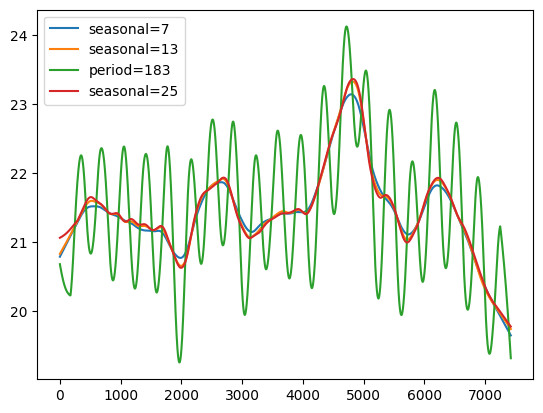

In [5]:
#testing STL parameters:

stl_s13 = STL(frc_all_clean, period=365, seasonal=13, robust=True)
res_s13 = stl_s13.fit()

stl_s7 = STL(frc_all_clean, period=365, seasonal=7, robust=True)
res_s7 = stl_s7.fit()

stl_p183 = STL(frc_all_clean, period=183, seasonal=7, robust=True)
res_p183 = stl_p183.fit()

stl_s25 = STL(frc_all_clean, period=365, seasonal=25, robust=True)
res_s25 = stl_s25.fit()

plt.plot(res_s7.trend, label='seasonal=7')
plt.plot(res_s13.trend,label='seasonal=13')
plt.plot(res_p183.trend, label='period=183')
plt.plot(res_s25.trend, label='seasonal=25')
plt.legend()

/tmp/ipykernel_345863/2333125011.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation = 45)
/tmp/ipykernel_345863/2333125011.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation = 45)


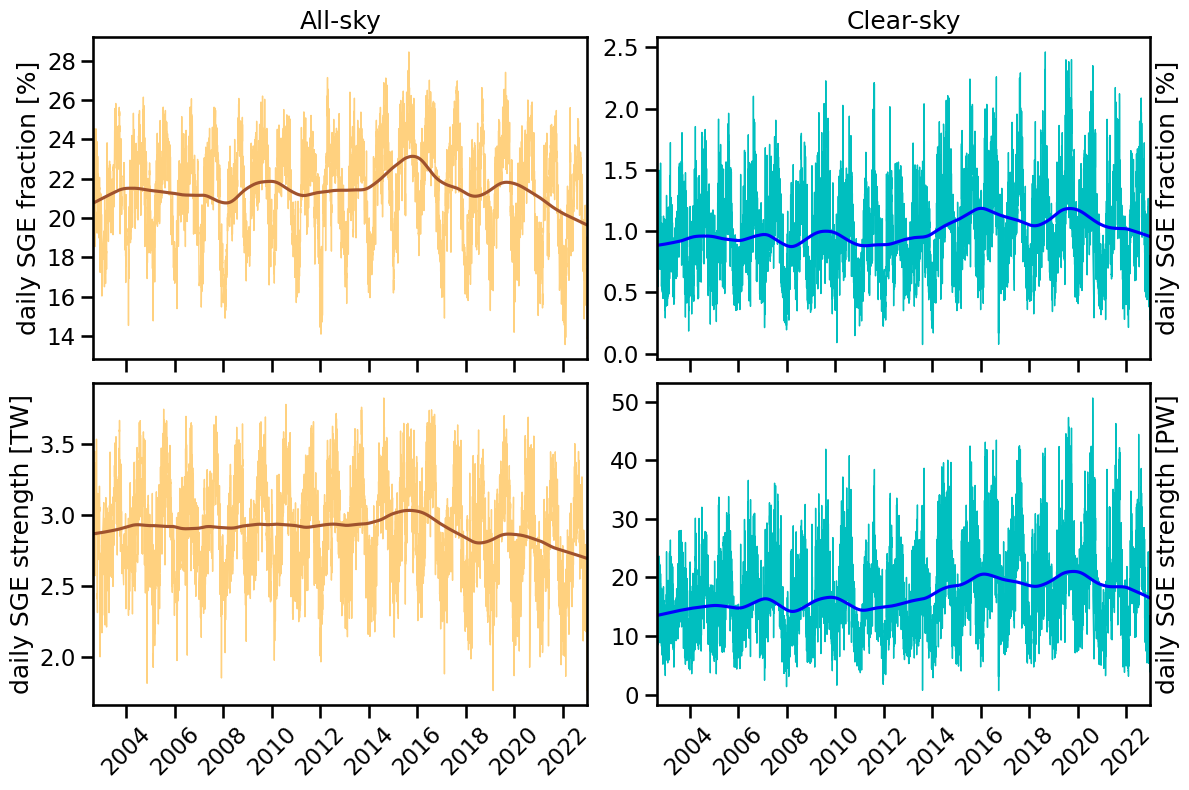

In [60]:
#Figure 1, timeseries trends
with sns.plotting_context("talk"):

    fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=True)
    axes[0,0].plot(frc_all_clean.time, frc_all_clean,color='orange',linewidth=1,alpha=0.5)
    axes[0,0].plot(frc_all_clean.time, res_frALL.trend,color='sienna')
    axes[0,0].autoscale(enable=True, axis='x', tight=True)
    axes[0,0].set_title('All-sky')
    axes[0,0].set_ylabel('daily SGE fraction [%]')
    
    axes[0,1].plot(frc_clr_clean.time, frc_clr_clean, linewidth=1,color='c')
    axes[0,1].plot(frc_clr_clean.time, res_frCLR.trend, color='b')
    axes[0,1].set_title('Clear-sky')
    axes[0,1].autoscale(enable=True, axis='x', tight=True)
    #axes[0,1].yaxis.tick_right()
    axes[0,1].yaxis.set_label_position("right")
    axes[0,1].set_ylabel('daily SGE fraction [%]')

    axes[1,0].plot(pw_all_clean.time, pw_all_clean,color='orange',linewidth=1,alpha=0.5)
    axes[1,0].plot(pw_all_clean.time, res_pwALL.trend,color='sienna')
    axes[1,0].autoscale(enable=True, axis='x', tight=True)
    axes[1,0].set_ylabel('daily SGE strength [TW]')
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation = 45)

    axes[1,1].plot(pw_clr_clean.time, pw_clr_clean, linewidth=1,color='c')
    axes[1,1].plot(pw_clr_clean.time, res_pwCLR.trend, color='b')
    axes[1,1].autoscale(enable=True, axis='x', tight=True)
    #axes[1,1].yaxis.tick_right()
    axes[1,1].yaxis.set_label_position("right")
    axes[1,1].set_ylabel('daily SGE strength [PW]')
    axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation = 45)

fig.tight_layout()


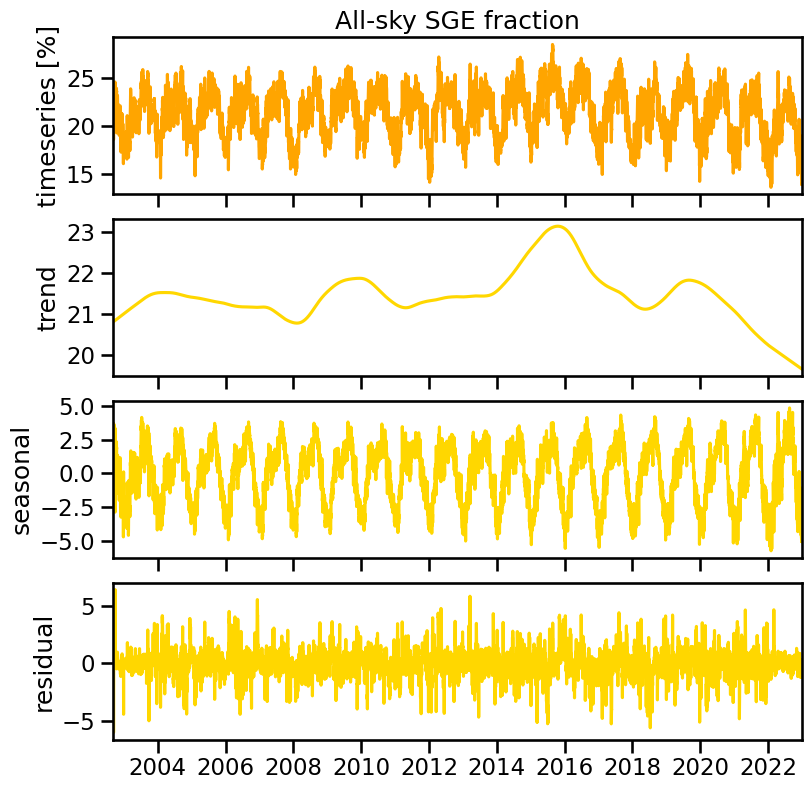

In [21]:
#plot full decomposition of each timeseries for supplimentary:

with sns.plotting_context("talk"):
    fig, axes = plt.subplots(4,1, figsize=(8,8), sharex=True)
    axes[0].plot(frc_all_clean.time, frc_all_clean,color='orange')
    axes[0].autoscale(enable=True, axis='x', tight=True)
    axes[0].set_title('All-sky SGE fraction')
    axes[0].set_ylabel('timeseries [%]')

    axes[1].plot(frc_all_clean.time, res_frALL.trend,color='gold')
    axes[1].autoscale(enable=True, axis='x', tight=True)
    axes[1].set_ylabel('trend')

    axes[2].plot(frc_all_clean.time, res_frALL.seasonal,color='gold')
    axes[2].autoscale(enable=True, axis='x', tight=True)
    axes[2].set_ylabel('seasonal')

    axes[3].plot(frc_all_clean.time, res_frALL.resid,color='gold')
    axes[3].autoscale(enable=True, axis='x', tight=True)
    axes[3].set_ylabel('residual')

fig.tight_layout()

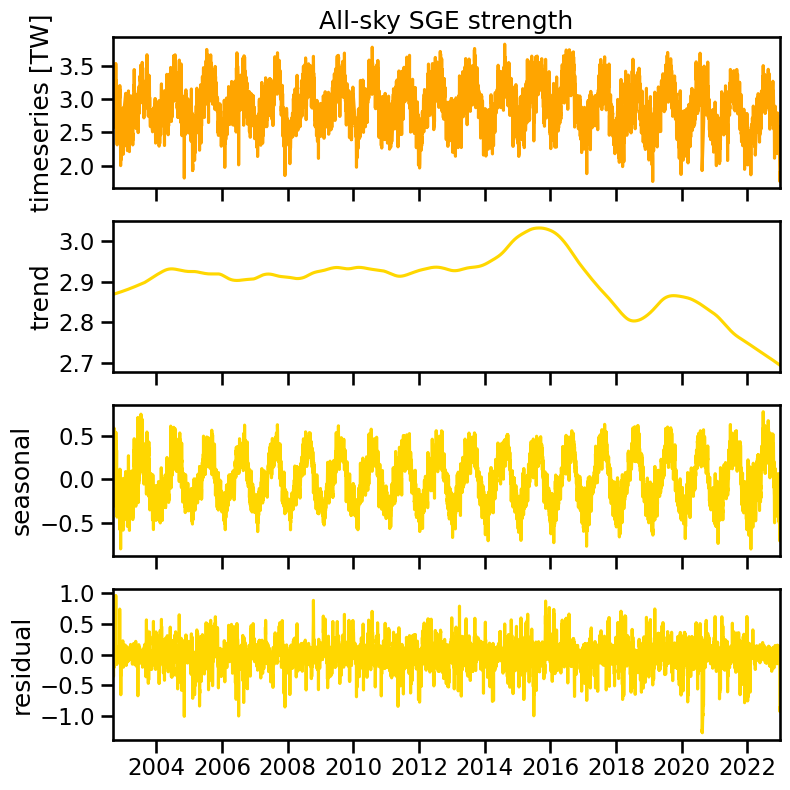

In [22]:
#plot full decomposition of each timeseries for supplimentary:

with sns.plotting_context("talk"):
    fig, axes = plt.subplots(4,1, figsize=(8,8), sharex=True)
    axes[0].plot(pw_all_clean.time, pw_all_clean,color='orange')
    axes[0].autoscale(enable=True, axis='x', tight=True)
    axes[0].set_title('All-sky SGE strength')
    axes[0].set_ylabel('timeseries [TW]')

    axes[1].plot(pw_all_clean.time, res_pwALL.trend,color='gold')
    axes[1].autoscale(enable=True, axis='x', tight=True)
    axes[1].set_ylabel('trend')

    axes[2].plot(pw_all_clean.time, res_pwALL.seasonal,color='gold')
    axes[2].autoscale(enable=True, axis='x', tight=True)
    axes[2].set_ylabel('seasonal')

    axes[3].plot(pw_all_clean.time, res_pwALL.resid,color='gold')
    axes[3].autoscale(enable=True, axis='x', tight=True)
    axes[3].set_ylabel('residual')

fig.tight_layout()

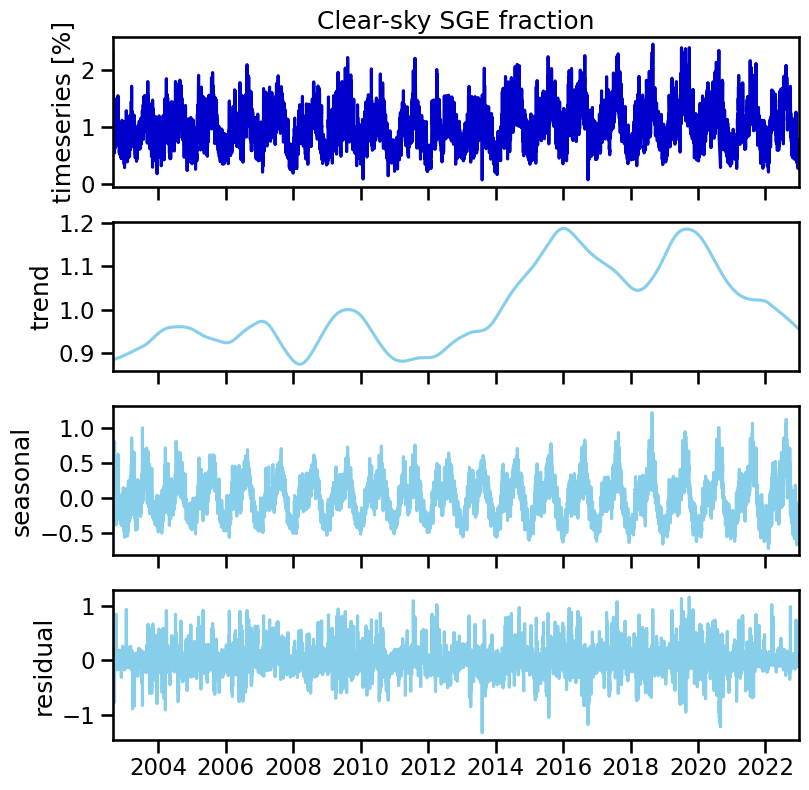

In [25]:
#plot full decomposition of each timeseries for supplimentary:

with sns.plotting_context("talk"):
    fig, axes = plt.subplots(4,1, figsize=(8,8), sharex=True)
    axes[0].plot(frc_clr_clean.time, frc_clr_clean,color='mediumblue')
    axes[0].autoscale(enable=True, axis='x', tight=True)
    axes[0].set_title('Clear-sky SGE fraction')
    axes[0].set_ylabel('timeseries [%]')

    axes[1].plot(frc_clr_clean.time, res_frCLR.trend,color='skyblue')
    axes[1].autoscale(enable=True, axis='x', tight=True)
    axes[1].set_ylabel('trend')

    axes[2].plot(frc_clr_clean.time, res_frCLR.seasonal,color='skyblue')
    axes[2].autoscale(enable=True, axis='x', tight=True)
    axes[2].set_ylabel('seasonal')

    axes[3].plot(frc_clr_clean.time, res_frCLR.resid,color='skyblue')
    axes[3].autoscale(enable=True, axis='x', tight=True)
    axes[3].set_ylabel('residual')

fig.tight_layout()

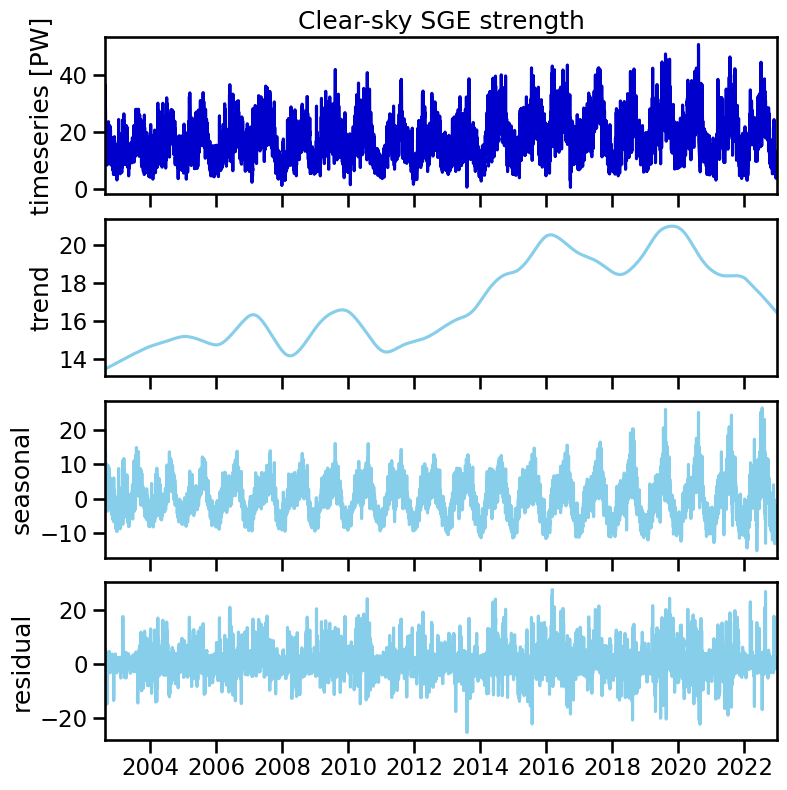

In [26]:
#plot full decomposition of each timeseries for supplimentary:

with sns.plotting_context("talk"):
    fig, axes = plt.subplots(4,1, figsize=(8,8), sharex=True)
    axes[0].plot(pw_clr_clean.time, pw_clr_clean,color='mediumblue')
    axes[0].autoscale(enable=True, axis='x', tight=True)
    axes[0].set_title('Clear-sky SGE strength')
    axes[0].set_ylabel('timeseries [PW]')

    axes[1].plot(pw_clr_clean.time, res_pwCLR.trend,color='skyblue')
    axes[1].autoscale(enable=True, axis='x', tight=True)
    axes[1].set_ylabel('trend')

    axes[2].plot(pw_clr_clean.time, res_pwCLR.seasonal,color='skyblue')
    axes[2].autoscale(enable=True, axis='x', tight=True)
    axes[2].set_ylabel('seasonal')

    axes[3].plot(pw_clr_clean.time, res_pwCLR.resid,color='skyblue')
    axes[3].autoscale(enable=True, axis='x', tight=True)
    axes[3].set_ylabel('residual')

fig.tight_layout()

In [48]:
#Figure 2: Annual cycles

#transform to dataframe with column for each year
#df_frALL = frc_all_clean.resample(time='MS').mean().to_dataframe()
#df_frALL['year'] = df_frALL.index.year
#df_frALL['month'] = df_frALL.index.month

df_pwALL = pw_all.to_dataframe()
df_pwALL['year'] = df_pwALL.index.year
df_pwALL['DayOfYear'] = df_pwALL.index.dayofyear
df_frALL = frc_all.to_dataframe()
df_ALL = pd.concat([df_pwALL, df_frALL], axis=1)

df_pwCLR = pw_clr.to_dataframe()
df_pwCLR['year'] = df_pwCLR.index.year
df_pwCLR['DayOfYear'] = df_pwCLR.index.dayofyear
df_frCLR = frc_clr.to_dataframe()
df_CLR = pd.concat([df_pwCLR, df_frCLR], axis=1)



In [15]:
df_ALL

,SGE_pw_all,year,DayOfYear,SGE_frac_all
time,,,,
2002-08-22,NaN,2002,234,NaN
2002-08-23,NaN,2002,235,NaN
2002-08-24,NaN,2002,236,NaN
2002-08-25,NaN,2002,237,NaN
2002-08-26,NaN,2002,238,NaN
...,...,...,...,...
2022-12-27,2.117670,2022,361,14.552602
2022-12-28,1.918925,2022,362,14.185526
2022-12-29,1.944597,2022,363,13.842721


<Axes: xlabel='DayOfYear', ylabel='SGE_pw_all'>

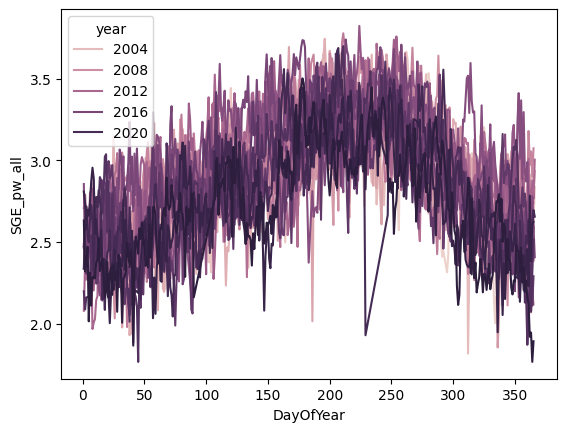

In [22]:
sns.lineplot(data=df_ALL, x='DayOfYear',y='SGE_pw_all',hue='year',markers='')

#hue=df["Data"].isna().cumsum()
#    , palette=["blue"]*sum(df["Data"].isna())

#https://stackoverflow.com/questions/62738353/plot-overlapped-different-year-trend

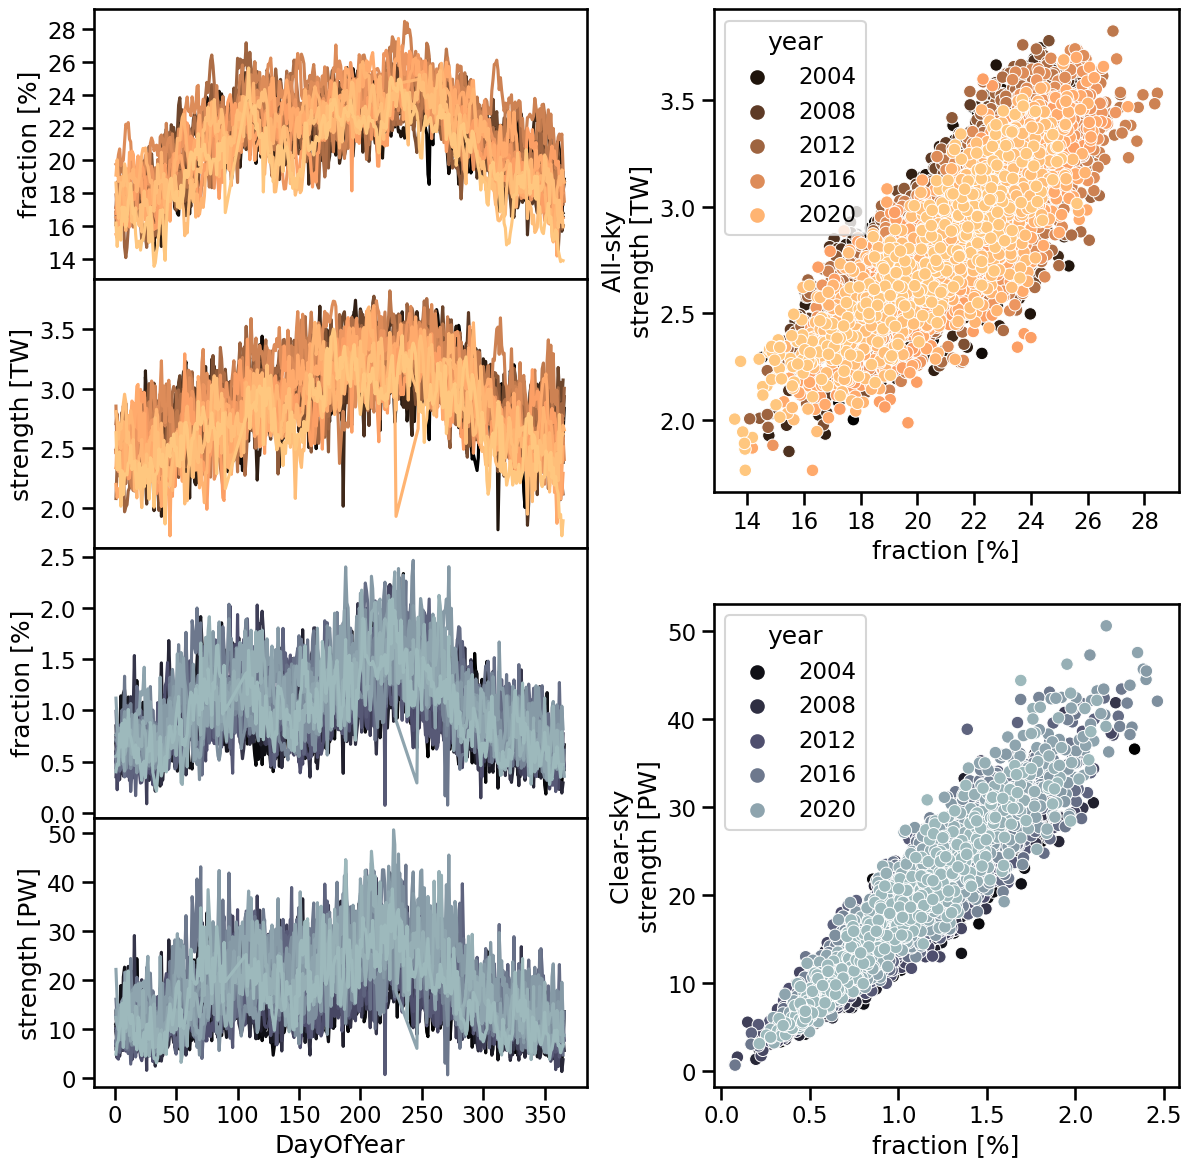

In [27]:

with sns.plotting_context("talk"):

    fig = plt.figure(figsize=(14,14))
    gs_left = gridspec.GridSpec(ncols=4, nrows=4, hspace = 0.0, wspace = 0.5)
    gs_right = gridspec.GridSpec(ncols=4, nrows=4, hspace=0.6, wspace=1)

    ax1 = fig.add_subplot(gs_left[0,0:2])
    sns.lineplot(ax=ax1,data=df_ALL, x='DayOfYear',y='SGE_frac_all',hue='year',palette='copper',legend=False)
    ax1.set_ylabel('fraction [%]')

    ax2 = fig.add_subplot(gs_left[1,0:2])
    sns.lineplot(ax=ax2,data=df_ALL, x='DayOfYear',y='SGE_pw_all',hue='year',palette='copper',legend=False)
    ax2.set_ylabel('strength [TW]')

    ax3 = fig.add_subplot(gs_left[2,0:2])
    sns.lineplot(data=df_CLR, x='DayOfYear',y='SGE_frac_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7),legend=False)
    ax3.set_ylabel('fraction [%]')

    ax4 = fig.add_subplot(gs_left[3,0:2])
    sns.lineplot(data=df_CLR, x='DayOfYear',y='SGE_pw_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7),legend=False)
    ax4.set_ylabel('strength [PW]')

    ax5 = fig.add_subplot(gs_right[0:2,2:4])
    sns.scatterplot(ax=ax5,data=df_ALL,x='SGE_frac_all',y='SGE_pw_all',hue='year',palette='copper')
    #sns.regplot(ax=ax5,data=df_ALL,x='SGE_frac_all',y='SGE_pw_all',scatter=False,color='orange',ci=None,robust=True)
    ax5.set_ylabel(' All-sky \nstrength [TW]')
    ax5.set_xlabel('fraction [%]')

    ax6 = fig.add_subplot(gs_right[2:4,2:4])
    sns.scatterplot(ax=ax6,data=df_CLR,x='SGE_frac_clr',y='SGE_pw_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7))
    #sns.regplot(ax=ax6,data=df_CLR,x='SGE_frac_clr',y='SGE_pw_clr',scatter=False,color='skyblue',ci=None,robust=True)
    ax6.set_ylabel(' Clear-sky \nstrength [PW]')
    ax6.set_xlabel('fraction [%]')

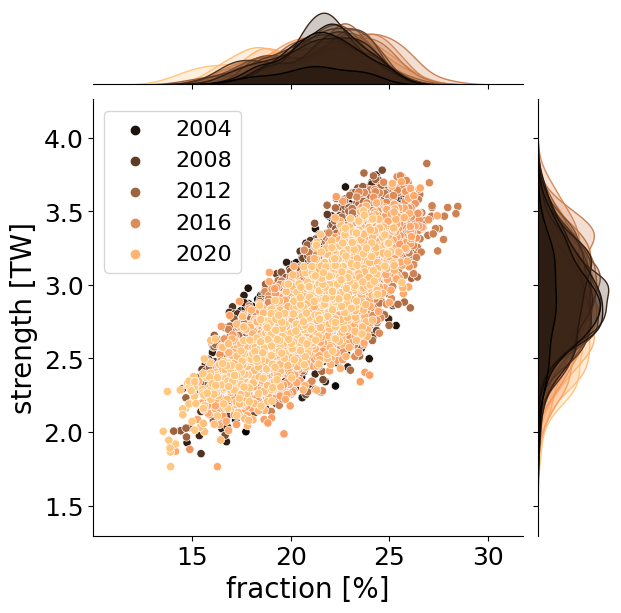

In [53]:
fig = sns.jointplot(data=df_ALL,x='SGE_frac_all',y='SGE_pw_all',hue='year',palette='copper')
plt.xlabel('fraction [%]',fontsize=20)
plt.ylabel('strength [TW]',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=16)


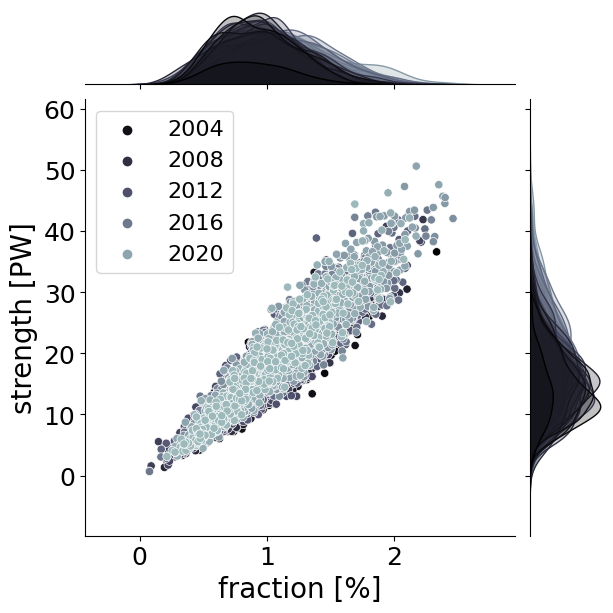

In [52]:
fig = sns.jointplot(data=df_CLR,x='SGE_frac_clr',y='SGE_pw_clr',hue='year',palette=cm.get_sub_cmap('bone', 0.0, 0.7))
plt.xlabel('fraction [%]',fontsize=20)
plt.ylabel('strength [PW]',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(fontsize=16)

In [5]:
#Figure 3: maps of frequency and strength

#seasonal means
occ_all_seas = SGE_ts.SGE_occ_all.groupby('time.season').mean('time')*100
occ_clr_seas = SGE_ts.SGE_occ_clr.groupby('time.season').mean('time')*100
str_all_seas = SGE_ts.SGE_str_all.groupby('time.season').mean('time')
str_clr_seas = SGE_ts.SGE_str_clr.groupby('time.season').mean('time')


In [15]:
str_all_seas.mean()

<xarray.DataArray 'SGE_str_all' ()>
array(15.737952, dtype=float32)

/tmp/ipykernel_345863/3833413323.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


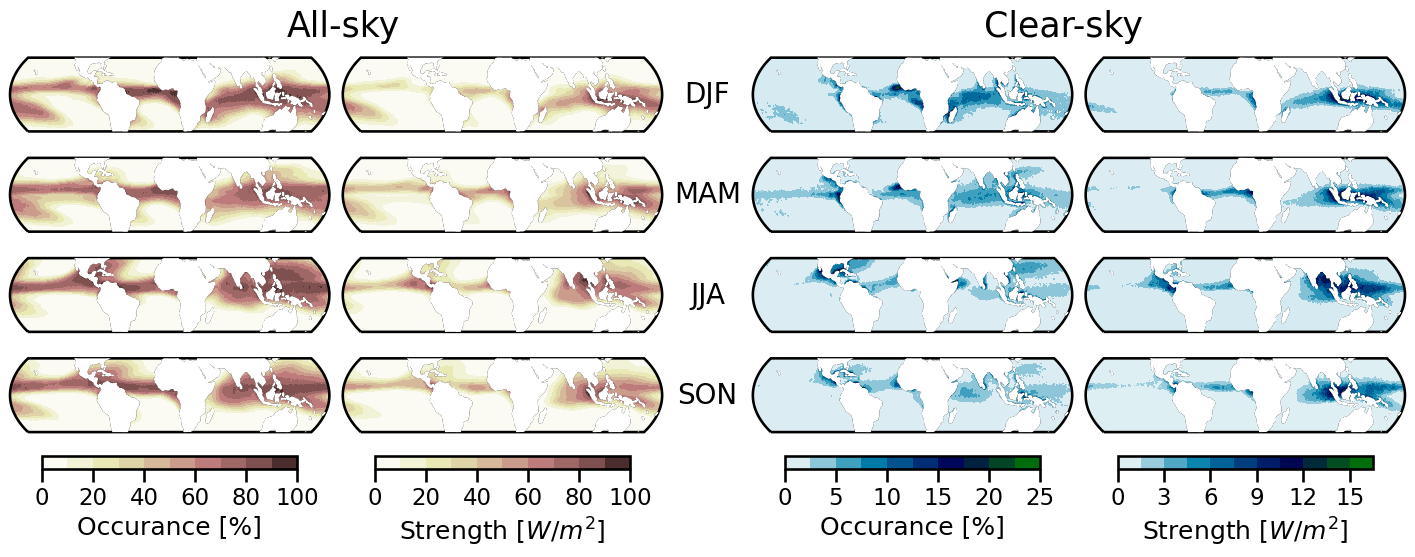

In [46]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

with sns.plotting_context('talk'):

    fig = plt.figure(figsize=(18,6))
    proj=ccrs.Mollweide()
    all_cmap = 'pink_r'
    clr_cmap = 'ocean_r'
    lats=occ_all_seas.lat
    lons=occ_all_seas.lon
    gs = gridspec.GridSpec(ncols=5, nrows=5, hspace = 0.0, wspace = 0.05, height_ratios=[1,1,1,1,0.43], width_ratios=[1,1,0.2,1,1])

    ax1 = fig.add_subplot(gs[0,0], projection=proj)
    plt.contourf(lons,lats,occ_all_seas.sel(season='DJF'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=5)
    plt.gca().coastlines()

    #plt.subplot(445, projection=proj)
    ax2 = fig.add_subplot(gs[1,0], projection=proj)
    plt.contourf(lons,lats,occ_all_seas.sel(season='MAM'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(449, projection=proj)
    ax3 = fig.add_subplot(gs[2,0], projection=proj)
    plt.contourf(lons,lats,occ_all_seas.sel(season='JJA'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax4=plt.subplot(4,4,13, projection=proj)
    ax4 = fig.add_subplot(gs[3,0], projection=proj)
    im=plt.contourf(lons,lats,occ_all_seas.sel(season='SON'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()
    ax5 = fig.add_subplot(gs[4,0], projection=proj)
    plt.colorbar(im,ax=ax5, location='bottom',label='Occurance [%]',fraction=0.75,shrink=0.8)
    fig.delaxes(ax5)


    #plt.subplot(442, projection=proj)
    ax7 = fig.add_subplot(gs[0,1], projection=proj)
    plt.contourf(lons,lats,str_all_seas.sel(season='DJF'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(446, projection=proj)
    ax8 = fig.add_subplot(gs[1,1], projection=proj)
    plt.contourf(lons,lats,str_all_seas.sel(season='MAM'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(4,4,10, projection=proj)
    ax9 = fig.add_subplot(gs[2,1], projection=proj)
    plt.contourf(lons,lats,str_all_seas.sel(season='JJA'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax5=plt.subplot(4,4,14, projection=proj)
    ax10 = fig.add_subplot(gs[3,1], projection=proj)
    im2=plt.contourf(lons,lats,str_all_seas.sel(season='SON'),10,transform=ccrs.PlateCarree(),cmap=all_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()
    ax11 = fig.add_subplot(gs[4,1], projection=proj)
    plt.colorbar(im2,ax=ax11, location='bottom',label='Strength [$W/m^2$]',fraction=0.75,shrink=0.8)
    fig.delaxes(ax11)


    #plt.subplot(443, projection=proj)
    ax12 = fig.add_subplot(gs[0,3], projection=proj)
    plt.contourf(lons,lats,occ_clr_seas.sel(season='DJF'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(447, projection=proj)
    ax13 = fig.add_subplot(gs[1,3], projection=proj)
    plt.contourf(lons,lats,occ_clr_seas.sel(season='MAM'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(4,4,11, projection=proj)
    ax13 = fig.add_subplot(gs[2,3], projection=proj)
    plt.contourf(lons,lats,occ_clr_seas.sel(season='JJA'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax6=plt.subplot(4,4,15, projection=proj)
    ax14 = fig.add_subplot(gs[3,3], projection=proj)
    im3=plt.contourf(lons,lats,occ_clr_seas.sel(season='SON'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()
    ax15 = fig.add_subplot(gs[4,3], projection=proj)
    plt.colorbar(im3,ax=ax15, location='bottom',label='Occurance [%]',fraction=0.75,shrink=0.8)
    fig.delaxes(ax15)   

    #plt.subplot(444, projection=proj)
    ax16 = fig.add_subplot(gs[0,4], projection=proj)
    plt.contourf(lons,lats,str_clr_seas.sel(season='DJF'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(448, projection=proj)
    ax17 = fig.add_subplot(gs[1,4], projection=proj)
    plt.contourf(lons,lats,str_clr_seas.sel(season='MAM'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #plt.subplot(4,4,12, projection=proj)
    ax18 = fig.add_subplot(gs[2,4], projection=proj)
    plt.contourf(lons,lats,str_clr_seas.sel(season='JJA'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()

    #ax7=plt.subplot(4,4,16, projection=proj)
    ax19 = fig.add_subplot(gs[3,4], projection=proj)
    im4= plt.contourf(lons,lats,str_clr_seas.sel(season='SON'),10,transform=ccrs.PlateCarree(),cmap=clr_cmap)
    plt.gca().add_feature(cartopy.feature.LAND, color='white',zorder=10)
    plt.gca().coastlines()
    ax20 = fig.add_subplot(gs[4,4], projection=proj)
    plt.colorbar(im4,ax=ax20, location='bottom',label='Strength [$W/m^2$]',fraction=0.75,shrink=0.8)
    fig.delaxes(ax20)

fig.tight_layout()
fig.subplots_adjust(top=0.85)  
plt.figtext(0.31,0.88,"All-sky", va="center", ha="center", size=25)
plt.figtext(0.71,0.88,"Clear-sky", va="center", ha="center", size=25)
#add labels into center column:
labels = ['DJF','MAM','JJA','SON']
for ii in range(4):
    ax_label = fig.add_subplot(gs[ii,2])
    ax_label.text(0.5,0.5,labels[ii], horizontalalignment='center', verticalalignment='center', transform=ax_label.transAxes, fontsize=20)
    ax_label.set_axis_off()




In [7]:
#Figure 4: maps of grid-wise trends
#remove seasonal cycle and fit linear trend gridwise, then plot slope in each gridpoint.

for ii in range(np.size(SGE_ts.lat)):
    for jj in range(np.size(SGE_ts.lon)):
        stl_occ = STL(SGE_ts.SGE_occ_all[:,ii,jj], period=365, robust=True)



ValueError: endog must have ndim <= 1

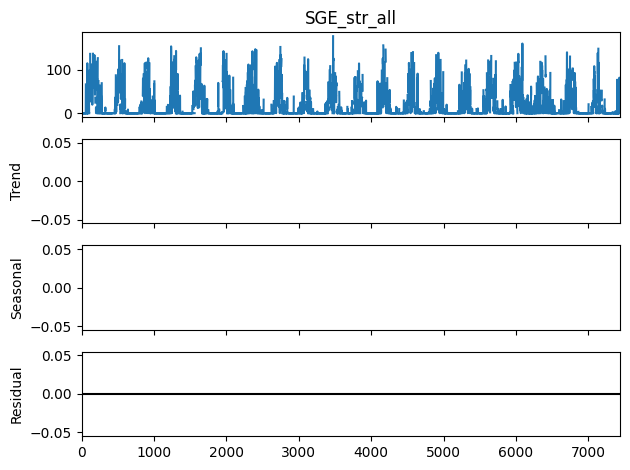

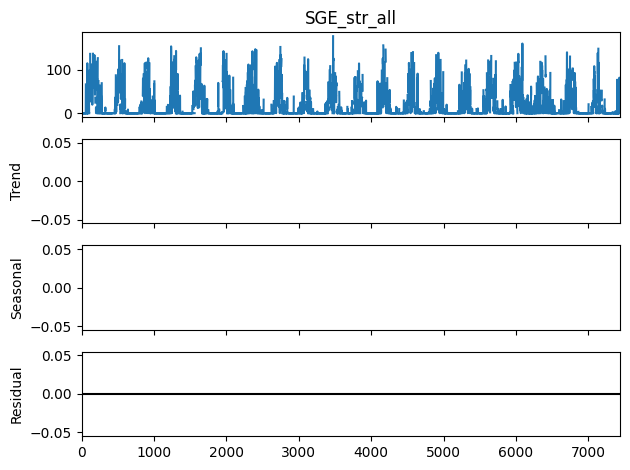

In [28]:
test_stl=STL(SGE_ts.SGE_str_all[:,20,50], period=365)
test_res = test_stl.fit()
test_res.plot()

#check if STL cannot handle zeros....

In [1]:
#power spectra:
y = SGE_timeseres['SGE_frac_clr']
fs = 1
from scipy import signal
f, Pper_spec = signal.welch(y, fs, 'hamming', detrend='linear', nperseg=256, scaling='spectrum')
plt.semilogy(f, Pper_spec)
plt.plot(1/30*np.ones((10,1)), np.linspace(min(Pper_spec),max(Pper_spec),num=10),'r--')
ax=plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels([f'{1/tick:.1f}' for tick in ticks])
plt.xlabel('period [days]')
plt.ylabel('PS')
plt.grid()
plt.tight_layout()


NameError: name 'SGE_timeseres' is not defined

''

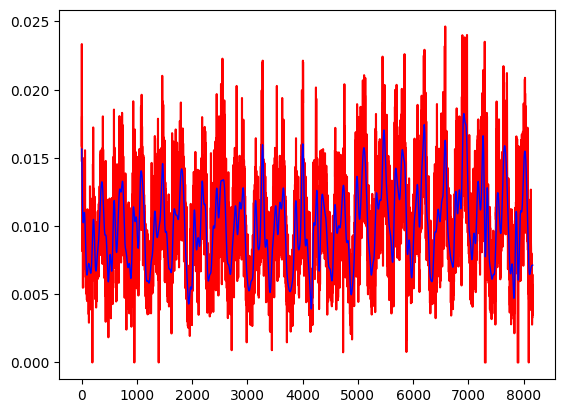

In [11]:
#10pt lowpass butterworth filter:
#copied from Mann 2008: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2008GL034716, http://www.meteo.psu.edu/holocene/public_html/smoothing08/
#(probably should re-write to proper python package sometime)
'''
def lowpass_mann(indata, f, iconb, icone):
    #f is the cutoff frequency (in cycles/time units)
    #icon is options for boundary constraints:
    # (0) minimum norm,
    # (1) minimum slope,
    # (2) minimum roughness
    padded=()
    ipts=10
    fn=f*2
    npad=3*round(1/fn)
    nn=len(indata)
    padded[npad:npad+nn-1]=indata
    padded[npad+nn:nn+2*npad-1]=indata[nn]
    padded[0:npad-1]=indata[1]
'''

cutoff = 1/30
b, a = signal.butter(10, cutoff, btype='lowpass') 
yfilt = signal.filtfilt(b, a, y, method='pad')
yfilt=np.array(yfilt)
yfilt=yfilt.transpose()

plt.plot(y,'r')
plt.plot(yfilt,'b',linewidth=1)

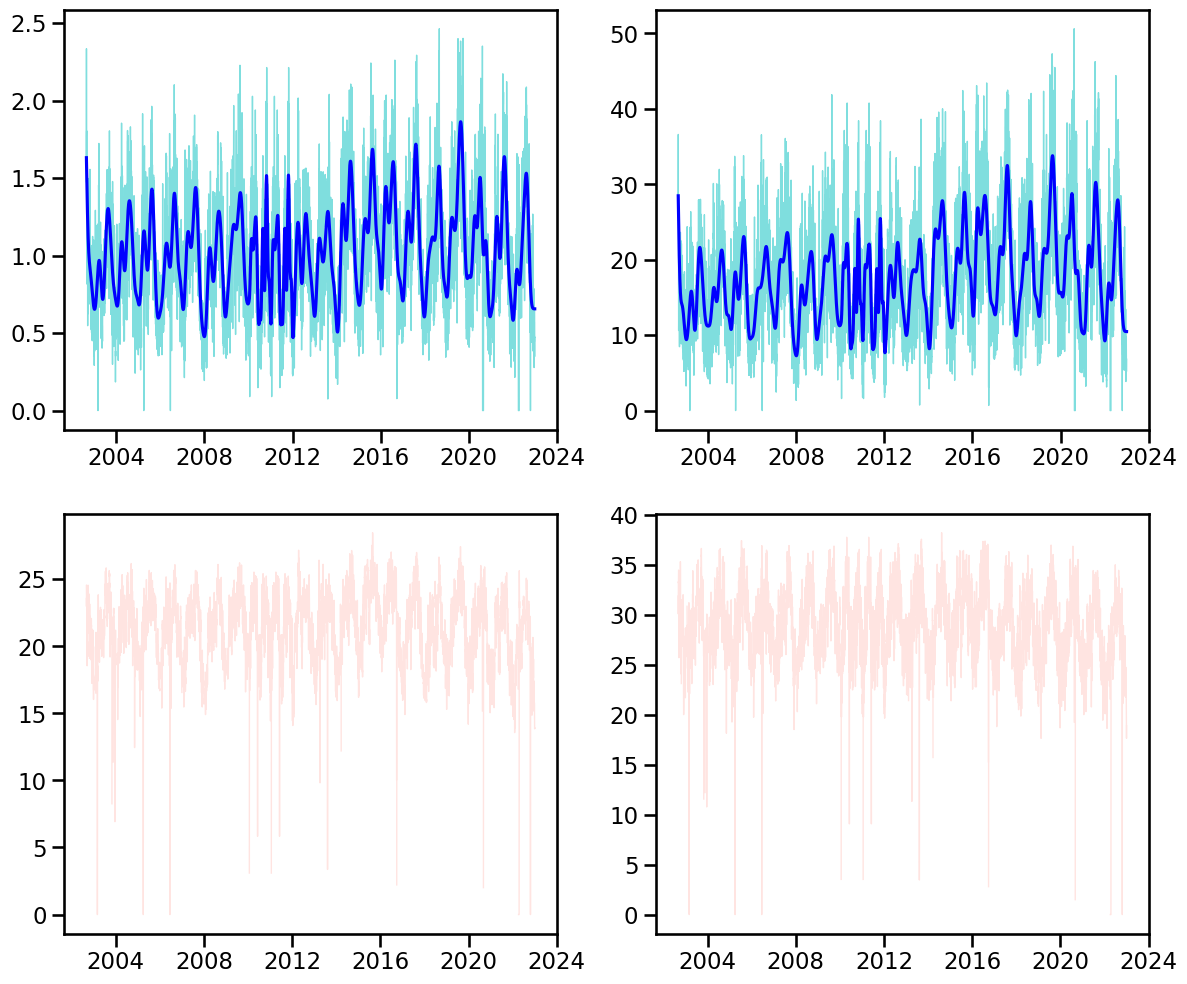

In [19]:
#Figure 1: timeseries of SGE frequency and strength for all-sky and clear-sky OLR:

def filter_ts(y,cutoff):
    b, a = signal.butter(10, cutoff, btype='lowpass') 
    yfilt = signal.filtfilt(b, a, y, method='pad')
    yfilt = np.array(yfilt)
    yfilt = yfilt.transpose()
    return yfilt

cf_filt = filter_ts(SGE_timeseres['SGE_frac_clr'], 1/45)
cs_filt = filter_ts(SGE_timeseres['SGE_pw_clr'], 1/45)
af_filt = filter_ts(SGE_timeseres['SGE_frac_all'], 1/45)
as_filt = filter_ts(SGE_timeseres['SGE_pw_all'], 1/45)

X = SGE_timeseres['time'].sortby(SGE_timeseres['time'])

import seaborn as sns
import matplotlib.colors as mcolors

with sns.plotting_context("talk"):

    fig, axes = plt.subplots(2, 2, figsize=(14,12))
    axes[0,0].plot(X, SGE_timeseres['SGE_frac_clr']*100,'c',linewidth=1,alpha=0.5)
    axes[0,0].plot(X, cf_filt*100,'b')

    axes[0,1].plot(X,SGE_timeseres['SGE_pw_clr']/1e12,'c',linewidth=1,alpha=0.5)
    axes[0,1].plot(X, cs_filt/1e12,'b')

    axes[1,0].plot(X, SGE_timeseres['SGE_frac_all']*100,linewidth=1,color='mistyrose')
    axes[1,0].plot(X, af_filt*100,color='sienna')

    axes[1,1].plot(X, SGE_timeseres['SGE_pw_all']/1e14,linewidth=1,color='mistyrose')
    axes[1,1].plot(X, as_filt*100,color='sienna')
    

        

    


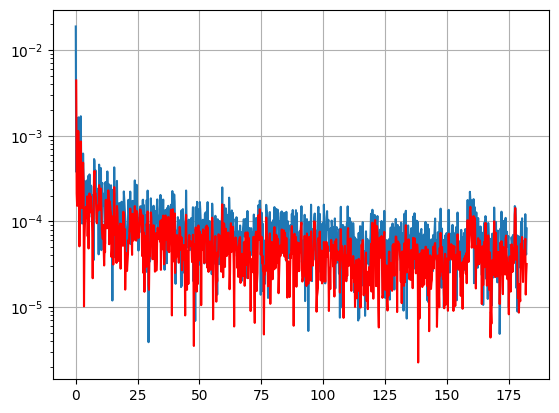

In [212]:
#SGE_timeseries = xr.open_dataset('SGE_timeseries.nc')

#1: deseasonalized timeseries of SGE global area fraction and strength

#plot dfft of fraction, check harmonics:
from scipy.fft import fft, fftfreq

N = len(SGE_frac_clr_clean)
T = 1/365
yf = fft(SGE_frac_clr_clean.values)
xf = fftfreq(N, T)[:N//2]
from scipy.signal import windows
w = windows.hamming(N)
ywf = fft(SGE_frac_clr_clean.values*w)
plt.semilogy(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')
plt.grid()
plt.show()


In [17]:
af_filt

array([nan, nan, nan, ..., nan, nan, nan])

In [31]:

import seaborn as sns


with sns.plotting_context("talk"):

    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    for input in inputs:

        label=input.split('_')[1][:-3]
        X = xr.open_dataset(input)
        x = range(2015, 2101)
        
        kwargs = {}
        if label == "ssp245":
            kwargs['color'] = 'black'
            kwargs['ls'] = '--'
            kwargs['lw'] = '5'
        axes[0, 0].plot(x, X['CO2'], label=label, **kwargs)
        axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
        axes[0, 1].plot(x, X['CH4'], label=label, **kwargs)
        axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
        # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
        axes[1, 0].plot(x, convert(global_sum(X['SO2']*AREA_of_EARTH*1000*100)), label=label, **kwargs)
        axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (TgSO2 / year)")
        axes[1, 1].plot(x, convert(global_sum(X['BC']*AREA_of_EARTH*1000*100)), label=label, **kwargs)
        axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (TgBC / year)")

    axes[0, 0].set_title('CO2')
    axes[0, 1].set_title('CH4')
    axes[1, 0].set_title('SO2')
    axes[1, 1].set_title('BC')
    axes[0, 0].legend()
    plt.tight_layout()
plts:

Figure 1: The timeseries of area fraction of SGE and strength. Can you extend it by deseasonalized timeseries such that trends are more obvious. 
I would remove the first 4 or five harmonics which is like removing the seasonal cycle from the datasets. 
(give multiple options: detrended with seasonal cycle removed, and one detrended with harmonics removed)
Figure 3: Can make the right hand panal plots equal aspect ratios and the colorbar maybe over the full length of horizontal on the bottom?
(annual cycle - )
Figure 4: Can you make it 4 row plots with all-sky and clear-sky conditions next to each other.
(maps)
Can you make one extrafigure in which you show the maps but instead of of frequency can you show the trends: 
So remove the grid-specific annual cycle in frequency and strength with the 4 or 5 harmonics whichever you identify to be more applicable, 
and estimate a linear trend through the deseasonalized timeseries. That should show which areas actually show the strongest responses and 
will be the main message of the paper (in my opinion).


SyntaxError: invalid syntax (2857090418.py, line 24)